In [25]:
import numpy as np
import matplotlib.pyplot as plt
import random


In [ ]:
class harmonic_oscillator:
    def __init__(self, k, mass, x0, u0):
        self.constant = -(k / mass)
        self.initial_conditions = np.array([x0, u0])
        self.A = np.sqrt(np.square(x0)+(np.square(u0)/(-self.constant)))
        self.phi = np.arcsin(x0/self.A)
        self.omega = np.sqrt(-self.constant)
        self.period = 2*np.pi/self.omega

        self.generated_points = None
        self.sampled_points = None
        self.dt_used_for_generation = None # Add this
        self.t_final_used_for_generation = None # Add this
        self.all_gradients = None # Add this for storing gradients
    def calculate_coord_analyticaly(self, t):
        x = self.A * np.sin(self.omega*t+self.phi)
        u = self.A*self.omega* np.cos(self.omega*t+self.phi)
        return x, u
    def calculate_accelaration(self, x):
        return self.constant*x 
    def calculate_derivative(self, x, u):
        accelaration = self.calculate_accelaration(x)
        return np.array([u, accelaration])
    def move_interval(self, x, u, dt):
        step = self.calculate_derivative(x, u)*dt
        return np.array([x, u]) + step
    def generate_points(self, t_final, dt, analyticaly=False, save=False):
            points = []
            
            # Determine the time array
            # Use np.linspace for precise number of steps including t=0 and t_final
            # Or, adjust np.arange to definitely include t=0 and the intended t_final
            # Let's use arange and ensure t=0 is handled.
            
            time_points = np.arange(0, t_final + dt, dt) # This array now starts at 0

            if analyticaly==False:
                current_position = self.initial_conditions
                for time in time_points: # Iterate through the proper time points
                    points.append(np.array([current_position[0], current_position[1], time]))
                    current_position = self.move_interval(current_position[0], current_position[1], dt)
            else: # analyticaly==True
                for time in time_points: # Iterate through the proper time points
                    x, u = self.calculate_coord_analyticaly(time)
                    points.append(np.array([x, u, time]))
            
            if save == True:
                self.generated_points = points
                self.dt_used_for_generation = dt 
                self.t_final_used_for_generation = t_final
            return points
    def sample_points(self, sample_ratio, n_segments, random_segments=False, save=True):
        num_points = len(self.generated_points)
        num_samples_overall = int(num_points * sample_ratio)

        if n_segments <= 0:
            raise ValueError("n_segments must be a positive integer.")
        if num_samples_overall == 0:
            return []
        
        num_samples_per_segment = num_samples_overall // n_segments
        if num_samples_per_segment == 0:
            print(f"Warning: With {num_points} points, {sample_ratio} ratio, and {n_segments} segments, you'll get less than 1 sample per segment. Adjusting to sample 1 point from {num_samples_overall} segments.")
            num_samples_per_segment = 1
            n_segments = min(n_segments, num_samples_overall) # Adjust n_segments to actual samples

        segment_length = num_points // n_segments
        
        # Ensure we don't try to sample more points than available in a segment
        if num_samples_per_segment > segment_length:
            raise ValueError(f"num_samples_per_segment ({num_samples_per_segment}) is greater than "
                             f"the segment length ({segment_length}). Adjust sample_ratio or n_segments.")

        sampled_points = []
        
        if random_segments:
            for i in range(n_segments):
                # Define the bounds for choosing a center for this specific conceptual segment
                start_boundary = i * (num_points // n_segments)
                end_boundary = (i + 1) * (num_points // n_segments)
                
                # Adjust end_boundary for the last segment
                if i == n_segments - 1:
                    end_boundary = num_points


                
                valid_min_start_index = start_boundary
                valid_max_start_index = end_boundary - num_samples_per_segment
                
                if valid_min_start_index > valid_max_start_index:
                    # This segment is too small to fit the desired number of samples
                    # print(f"Warning: Segment {i} cannot fit {num_samples_per_segment} samples. Skipping or taking what's available.")
                    if end_boundary - start_boundary > 0:
                        # Take as many as possible if the segment has points
                        num_to_take = min(num_samples_per_segment, end_boundary - start_boundary)
                        start_idx = random.randint(start_boundary, end_boundary - num_to_take)
                        sampled_points.extend(self.generated_points[start_idx : start_idx + num_to_take])
                    continue # Skip to next segment

                random_start_index = random.randint(valid_min_start_index, valid_max_start_index)
                
                # Add points to the list
                sampled_points.extend(self.generated_points[random_start_index : random_start_index + num_samples_per_segment])

        else: # Equally separated segments
            step_between_segments = num_points // n_segments
            
            # Calculate the effective sample size to prevent index errors
            # if num_samples_per_segment is large relative to step_between_segments
            effective_sample_size = min(num_samples_per_segment, step_between_segments)

            for i in range(n_segments):
                segment_start_index = i * step_between_segments
                
                # Ensure we don't go out of bounds when taking consecutive points
                # The end index should not exceed num_points
                end_index_for_segment = min(segment_start_index + effective_sample_size, num_points)
                
                # If a segment is empty due to rounding, skip
                if segment_start_index >= end_index_for_segment:
                    continue

                sampled_points.extend(self.generated_points[segment_start_index : end_index_for_segment])
        

        if save==True:
            self.sampled_points=sampled_points[:num_samples_overall]
        return sampled_points[:num_samples_overall]


    def calculate_all_gradients(self, save=True):
        if self.generated_points is None:
            raise ValueError("No points generated yet. Call 'generate_points' first.")
        
        gradients = []
        for point in self.generated_points:
            x, u = point[0], point[1]
            gradient_vector = self.calculate_derivative(x, u)
            gradients.append(gradient_vector)
        
        if save:
            self.all_gradients = np.array(gradients)
        return np.array(gradients)
    




    def plot_points(self, show_sampled=False, show_derivative=False, show_generated=True):
        """
        Plot phase space trajectory (velocity vs position).
        
        Parameters:
        show_sampled: bool - If True, plot sampled points in a different color.
        show_derivative: bool - If True, plot gradient arrows at generated points.
        show_generated: bool - If True, plot all generated points.
        """
        if self.generated_points is None:
            raise ValueError("No points have been generated yet. Call 'generate_points' first.")
        
        # Retrieve dt and t_final from saved attributes
        dt = self.dt_used_for_generation
        t_final = self.t_final_used_for_generation

        # Convert generated_points to numpy array for easier handling
        gen_points_np = np.array(self.generated_points)
        x_gen = gen_points_np[:, 0]
        u_gen = gen_points_np[:, 1]
        time_gen = gen_points_np[:, 2]

        plt.figure(figsize=(10, 8))
        
        # Plot generated points if requested
        if show_generated:
            plt.plot(x_gen, u_gen, 'b-', linewidth=1.5, alpha=0.7, label='Generated Trajectory')
            # Changed from scatter to plot to remove time-based coloring by default
            plt.plot(x_gen, u_gen, 'bo', markersize=3, alpha=0.4, label='Generated Points') 
            
            # Highlight initial point
            plt.scatter(x_gen[0], u_gen[0], color='red', s=100, zorder=5, label=f'Initial point (t={time_gen[0]:.3f})')
            plt.annotate(f't = {time_gen[0]:.3f}', xy=(x_gen[0], u_gen[0]), xytext=(10, 10), textcoords='offset points',bbox=dict(boxstyle='round,pad=0.3', facecolor='red', alpha=0.7),fontsize=10, color='white', weight='bold')
            
            # Highlight final point
            # Adjusting t_final_label for consistency with arange. 
            # If you modified generate_points to include t_final, this should be t_final.
            plt.scatter(x_gen[-1], u_gen[-1], color='orange', s=100, zorder=5, label=f'Final point (t={time_gen[-1]:.3f})') # <-- CHANGE HERE (use time_gen[-1])
            plt.annotate(f't = {time_gen[-1]:.3f}', xy=(x_gen[-1], u_gen[-1]), xytext=(-10, -20), textcoords='offset points',bbox=dict(boxstyle='round,pad=0.3', facecolor='orange', alpha=0.7),fontsize=10, color='white', weight='bold')
            
            # Add dt information as text box (if generated points are shown)
            plt.text(0.02, 0.98, f'dt = {dt}', transform=plt.gca().transAxes,bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8),fontsize=11, verticalalignment='top')
            
            # Remove colorbar for time for generated points as requested.

        # Plot sampled points if requested
        if show_sampled:
            if self.sampled_points is None:
                raise ValueError("No points have been sampled yet. Call 'sample_points' first or ensure 'save=True'.")
            
            sampled_points_np = np.array(self.sampled_points)
            x_sampled = sampled_points_np[:, 0]
            u_sampled = sampled_points_np[:, 1]
            plt.scatter(x_sampled, u_sampled, color='red', marker='x', s=50, zorder=3, label='Sampled Points')

        # Plot derivatives (quiver plot) if requested
        if show_derivative:
            if self.all_gradients is None:
                raise ValueError("No gradients have been calculated yet. Call 'calculate_all_gradients' first or ensure 'save=True'.")
            
            gradients_np = self.all_gradients
            
            # The u and v components for quiver are the derivative values
            # u_vec is dx/dt (velocity), v_vec is du/dt (acceleration)
            u_vec = gradients_np[:, 0] 
            v_vec = gradients_np[:, 1]
            
            # Calculate magnitude for coloring
            magnitudes = np.sqrt(u_vec**2 + v_vec**2)
            
            # Use plt.quiver to plot arrows
            # scale_units='xy' and scale=1 makes arrows represent the actual magnitude in data units
            # angles='xy' ensures arrows point correctly in data coordinates
            quiv = plt.quiver(x_gen, u_gen, u_vec, v_vec, magnitudes, 
                              cmap='viridis', scale_units='xy', scale=None, alpha=0.7,
                              headwidth=4, headlength=6, pivot='middle', label='Gradients (Velocity, Acceleration)')
            plt.colorbar(quiv, label='Gradient Magnitude')


        plt.xlabel('Position (x)', fontsize=12)
        plt.ylabel('Velocity (u)', fontsize=12)
        plt.title(f'Phase Space Plot - Harmonic Oscillator', fontsize=14)
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.show()





        
class PhaseSpace:
    def __init__(self, k, mass):
        self.oscillators = []
        self.k = k
        self.mass = mass
        self.max_x0_param = None # Store these for potential plotting info
        self.max_u0_param = None # Store these for potential plotting info
        self.n_oscillators = None

        self.all_oscillators_generated_points_flat = None 
        self.all_oscillators_gradients_flat = None
        self.all_oscillators_sampled_points_flat = None
        self.dt_used_for_phase_space_generation = None # For plotting info
        self.t_final_used_for_phase_space_generation = None # For plotting info

    def make_oscillators(self, n_oscillators, max_x0, max_u0, method):
        self.oscillators = [] # Clear existing oscillators if called multiple times
        self.n_oscillators = n_oscillators
        self.max_x0_param = max_x0
        self.max_u0_param = max_u0

        if method == 'fully_random':
            for i in range(n_oscillators):
                # x0 can be positive or negative
                random_x0 = np.random.uniform(-max_x0, max_x0) 
                # u0 can be positive or negative
                random_u0 = np.random.uniform(-max_u0, max_u0)
                new_oscillator = harmonic_oscillator(k=self.k, mass=self.mass, x0=random_x0, u0=random_u0)
                self.oscillators.append(new_oscillator)

        elif method == 'random_energies':
            # Total energy E = 0.5 * m * u^2 + 0.5 * k * x^2
            # Max energy defined by the corners of the phase space box
            max_energy_corner1 = 0.5 * (self.mass * (max_u0**2) + self.k * (max_x0**2))
            # Max energy considering only u0 (x0=0) or only x0 (u0=0)
            max_energy_u = 0.5 * self.mass * (max_u0**2)
            max_energy_x = 0.5 * self.k * (max_x0**2)
            max_energy = max(max_energy_corner1, max_energy_u, max_energy_x)

            for i in range(n_oscillators):
                random_energy = np.random.uniform(0.001, max_energy) # Ensure positive energy
                
                # For a given energy E, x must be within [-sqrt(2E/k), sqrt(2E/k)]
                x_limit_for_energy = np.sqrt(2 * random_energy / self.k)
                # Cap x0 to max_x0 parameter given
                actual_x0_limit = min(max_x0, x_limit_for_energy)

                # Randomly choose x0 within the allowed range for this energy AND max_x0
                random_x0 = np.random.uniform(-actual_x0_limit, actual_x0_limit)
                
                # Calculate u0 (can be positive or negative)
                # u^2 = (2E - kx^2) / m
                u_squared = (2 * random_energy - (self.k * (random_x0**2))) / self.mass
                
                # Ensure u_squared is not negative due to floating point inaccuracies
                u_squared = max(0, u_squared) 

                derived_u0_magnitude = np.sqrt(u_squared)
                
                # Randomly assign sign to u0
                derived_u0 = derived_u0_magnitude * np.random.choice([-1, 1])
                
                # Cap u0 to max_u0 parameter given
                if abs(derived_u0) > max_u0:
                    derived_u0 = np.sign(derived_u0) * max_u0

                new_oscillator = harmonic_oscillator(k=self.k, mass=self.mass, x0=random_x0, u0=derived_u0)
                self.oscillators.append(new_oscillator)

        elif method == 'stratified_energies':
            max_energy_corner1 = 0.5 * (self.mass * (max_u0**2) + self.k * (max_x0**2))
            max_energy_u = 0.5 * self.mass * (max_u0**2)
            max_energy_x = 0.5 * self.k * (max_x0**2)
            max_energy = max(max_energy_corner1, max_energy_u, max_energy_x)
            
            # Ensure energy starts above zero to avoid division by zero or sqrt(0) issues for x_limit
            energy_min = 0.001 
            energy_interval = (max_energy - energy_min) / n_oscillators
            
            for i in range(n_oscillators):
                current_energy = energy_min + i * energy_interval
                
                x_limit_for_energy = np.sqrt(2 * current_energy / self.k)
                actual_x0_limit = min(max_x0, x_limit_for_energy)

                random_x0 = np.random.uniform(-actual_x0_limit, actual_x0_limit)
                
                u_squared = (2 * current_energy - (self.k * (random_x0**2))) / self.mass
                u_squared = max(0, u_squared)

                derived_u0_magnitude = np.sqrt(u_squared)
                derived_u0 = derived_u0_magnitude * np.random.choice([-1, 1])
                
                if abs(derived_u0) > max_u0:
                    derived_u0 = np.sign(derived_u0) * max_u0

                new_oscillator = harmonic_oscillator(k=self.k, mass=self.mass, x0=random_x0, u0=derived_u0)
                self.oscillators.append(new_oscillator)
        else:
            raise ValueError("Method must be 'fully_random', 'random_energies', or 'stratified_energies'.")
        
    def generate_all_oscillators_points(self, t_final, dt, analyticaly=False, save=True):
        if not self.oscillators:
            raise ValueError("No oscillators have been created yet. Call 'make_oscillators' first.")
        
        all_points_combined = []
        for osc in self.oscillators:
            # Each oscillator generates and saves its own points
            osc.generate_points(t_final=t_final, dt=dt, analyticaly=analyticaly, save=True)
            all_points_combined.extend(osc.generated_points)
        
        if save:
            self.all_oscillators_generated_points_flat = np.array(all_points_combined)
            self.dt_used_for_phase_space_generation = dt
            self.t_final_used_for_phase_space_generation = t_final
        return np.array(all_points_combined)

    def calculate_all_oscillators_gradients(self, save=True):
        if self.all_oscillators_generated_points_flat is None:
            raise ValueError("No generated points for all oscillators. Call 'generate_all_oscillators_points' first.")

        all_gradients_combined = []
        for osc in self.oscillators:
            # Each oscillator calculates and saves its own gradients
            # This will internally use osc.generated_points
            osc.calculate_all_gradients(save=True) 
            all_gradients_combined.extend(osc.all_gradients) # Assuming all_gradients is already a NumPy array
        
        if save:
            self.all_oscillators_gradients_flat = np.array(all_gradients_combined)
        return np.array(all_gradients_combined)
    
    def sample_all_oscillators_points(self, sample_ratio, n_segments, random_segments=False, save=True):
        if not self.oscillators:
            raise ValueError("No oscillators have been created yet. Call 'make_oscillators' first.")
        
        # Ensure points are generated for all oscillators first
        # We don't need to check self.all_oscillators_generated_points_flat here
        # because each oscillator's sample_points method will check its own generated_points.
        # However, to be safe, it's good practice to ensure generation happened at the PhaseSpace level.
        if self.all_oscillators_generated_points_flat is None:
            raise ValueError("Generated points for all oscillators not found. Call 'generate_all_oscillators_points' first.")

        all_sampled_points_combined = []
        for osc in self.oscillators:
            # Each oscillator samples its own generated_points
            # The 'save=True' here means the individual oscillator saves its sampled_points
            # We then extend our combined list with these points.
            sampled_from_this_osc = osc.sample_points(sample_ratio=sample_ratio, 
                                                      n_segments=n_segments, 
                                                      random_segments=random_segments, 
                                                      save=True) # Each oscillator saves its own sampled points
            all_sampled_points_combined.extend(sampled_from_this_osc)
        
        final_combined_sampled_points = np.array(all_sampled_points_combined)
        
        if save:
            self.all_oscillators_sampled_points_flat = final_combined_sampled_points
        return final_combined_sampled_points
    
    def plot_phase_space(self, show_sampled=False, show_derivative=False, show_generated=True, plot_limits=None):
        """
        Plots the phase space of all oscillators.
        
        Parameters:
        show_sampled: bool - If True, plots the sampled points.
        show_derivative: bool - If True, plots the gradient arrows.
        show_generated: bool - If True, plots all generated points/trajectories.
        plot_limits: tuple or None - (xmin, xmax, ymin, ymax) to set explicit plot limits.
        """
        if not self.oscillators:
            raise ValueError("No oscillators have been created yet. Call 'make_oscillators' first.")
        
        plt.figure(figsize=(10, 8))

        # Retrieve dt and t_final from saved attributes for plot title
        dt = self.dt_used_for_phase_space_generation
        t_final = self.t_final_used_for_phase_space_generation

        # Plot generated points/trajectories
        if show_generated:
            if self.all_oscillators_generated_points_flat is None:
                raise ValueError("No points generated for all oscillators. Call 'generate_all_oscillators_points' first.")
            
            # For plotting individual trajectories, we need to iterate through oscillators
            # rather than using the flattened list directly.
            for i, osc in enumerate(self.oscillators):
                gen_points_np = np.array(osc.generated_points)
                x_gen = gen_points_np[:, 0]
                u_gen = gen_points_np[:, 1]
                
                plt.plot(x_gen, u_gen, alpha=0.6, linewidth=0.8, 
                         color='blue' if len(self.oscillators) > 1 else 'blue', # Use consistent color or vary if desired
                         label=f'Oscillator {i+1} Trajectory' if len(self.oscillators) <= 5 else "_nolegend_")
                plt.plot(x_gen[0], u_gen[0], 'o', markersize=6, alpha=0.8, color='red' if len(self.oscillators) > 1 else 'red')
            
            if len(self.oscillators) > 5: # If many, put one collective label for initial points
                # Collect all initial points for a single scatter plot for clarity
                initial_x = [osc.generated_points[0][0] for osc in self.oscillators]
                initial_u = [osc.generated_points[0][1] for osc in self.oscillators]
                plt.scatter(initial_x, initial_u, color='red', marker='o', s=20, alpha=0.6, label='Initial Conditions')
            else: # If few, initial points are marked by the plot calls above.
                # Just add a single label for the trajectories if many
                if len(self.oscillators) > 1:
                    plt.plot([], [], 'b-', alpha=0.6, linewidth=0.8, label='Trajectories')
        # Plot sampled points
        if show_sampled:
            if self.all_oscillators_sampled_points_flat is None:
                raise ValueError("No points sampled for all oscillators. Call 'sample_all_oscillators_points' first or ensure 'save=True'.")
            
            sampled_points_np = self.all_oscillators_sampled_points_flat
            x_sampled = sampled_points_np[:, 0]
            u_sampled = sampled_points_np[:, 1]
            plt.scatter(x_sampled, u_sampled, color='purple', marker='x', s=50, zorder=3, label='Sampled Points')

        # Plot derivatives (quiver plot)
        if show_derivative:
            if self.all_oscillators_gradients_flat is None:
                raise ValueError("No gradients calculated for all oscillators. Call 'calculate_all_oscillators_gradients' first or ensure 'save=True'.")
            
            gradients_np = self.all_oscillators_gradients_flat
            # The x, u positions for the quiver arrows are the generated points themselves
            if self.all_oscillators_generated_points_flat is None: # Should not happen if gradients were calculated
                 raise ValueError("Generated points required for plotting derivatives.")
            
            x_quiver_pos = self.all_oscillators_generated_points_flat[:, 0]
            u_quiver_pos = self.all_oscillators_generated_points_flat[:, 1]

            u_vec = gradients_np[:, 0] 
            v_vec = gradients_np[:, 1]
            magnitudes = np.sqrt(u_vec**2 + v_vec**2)
            
            quiv = plt.quiver(x_quiver_pos, u_quiver_pos, u_vec, v_vec, magnitudes, 
                              cmap='viridis', scale_units='xy', scale=None, alpha=0.7,
                              headwidth=4, headlength=6, pivot='middle', label='Gradients')
            plt.colorbar(quiv, label='Gradient Magnitude')

        plt.xlabel('Position (x)', fontsize=12)
        plt.ylabel('Velocity (u)', fontsize=12)
        
        # Adjust title based on whether dt/t_final are available
        title_suffix = ""
        if dt is not None and t_final is not None:
            title_suffix = f" (t_final={t_final}, dt={dt})"
        plt.title(f'Phase Space of {len(self.oscillators)} Harmonic Oscillators{title_suffix}', fontsize=14)
        
        plt.grid(True, alpha=0.3)
        plt.legend()

        if plot_limits:
            plt.xlim(plot_limits[0], plot_limits[1])
            plt.ylim(plot_limits[2], plot_limits[3])
        elif self.max_x0_param is not None and self.max_u0_param is not None:
             plt.xlim(-self.max_x0_param * 1.5, self.max_x0_param * 1.5)
             plt.ylim(-self.max_u0_param * 1.5, self.max_u0_param * 1.5)

        plt.tight_layout()
        plt.show()
        
    
    


In [17]:
h = harmonic_oscillator(k=15, mass=10, x0=1, u0=5)


In [71]:
Phase = PhaseSpace(k=15, mass=10)

In [72]:
Phase.make_oscillators(n_oscillators=10, max_x0=20, max_u0=20, method='stratified_energies')

In [73]:
Phase.generate_all_oscillators_points(t_final=2*np.pi/Phase.oscillators[0].omega, dt=0.1, analyticaly=True, save=True)

array([[1.10434410e-02, 4.13081302e-03, 0.00000000e+00],
       [1.13727680e-02, 2.44749267e-03, 1.00000000e-01],
       [1.15317167e-02, 7.27505790e-04, 2.00000000e-01],
       ...,
       [8.20140594e+00, 2.18724420e+01, 5.00000000e+00],
       [1.03217524e+01, 2.04814660e+01, 5.10000000e+00],
       [1.22874661e+01, 1.87836518e+01, 5.20000000e+00]], shape=(530, 3))

In [74]:
Phase.sample_all_oscillators_points(sample_ratio=0.6, n_segments=10, random_segments=True, save=True)

array([[ 1.10434410e-02,  4.13081302e-03,  0.00000000e+00],
       [ 1.13727680e-02,  2.44749267e-03,  1.00000000e-01],
       [ 1.15317167e-02,  7.27505790e-04,  2.00000000e-01],
       [ 1.09754175e-02, -4.39435036e-03,  5.00000000e-01],
       [ 1.04548675e-02, -6.00363384e-03,  6.00000000e-01],
       [ 9.77769033e-03, -7.52297533e-03,  7.00000000e-01],
       [ 4.47018965e-03, -1.30394059e-02,  1.20000000e+00],
       [ 3.13602194e-03, -1.36105859e-02,  1.30000000e+00],
       [ 1.75487266e-03, -1.39778622e-02,  1.40000000e+00],
       [ 3.47433178e-04, -1.41357326e-02,  1.50000000e+00],
       [-1.06521129e-03, -1.40818318e-02,  1.60000000e+00],
       [-2.46189755e-03, -1.38169675e-02,  1.70000000e+00],
       [-7.48068460e-03, -1.07730700e-02,  2.10000000e+00],
       [-8.49926531e-03, -9.57307337e-03,  2.20000000e+00],
       [-9.39051632e-03, -8.22966006e-03,  2.30000000e+00],
       [-1.07397286e-02, -5.19493450e-03,  2.50000000e+00],
       [-1.11774770e-02, -3.54908626e-03

In [75]:
Phase.calculate_all_oscillators_gradients(save=True)

array([[ 4.13081302e-03, -1.65651615e-02],
       [ 2.44749267e-03, -1.70591521e-02],
       [ 7.27505790e-04, -1.72975751e-02],
       ...,
       [ 2.18724420e+01, -1.23021089e+01],
       [ 2.04814660e+01, -1.54826287e+01],
       [ 1.87836518e+01, -1.84311991e+01]], shape=(530, 2))

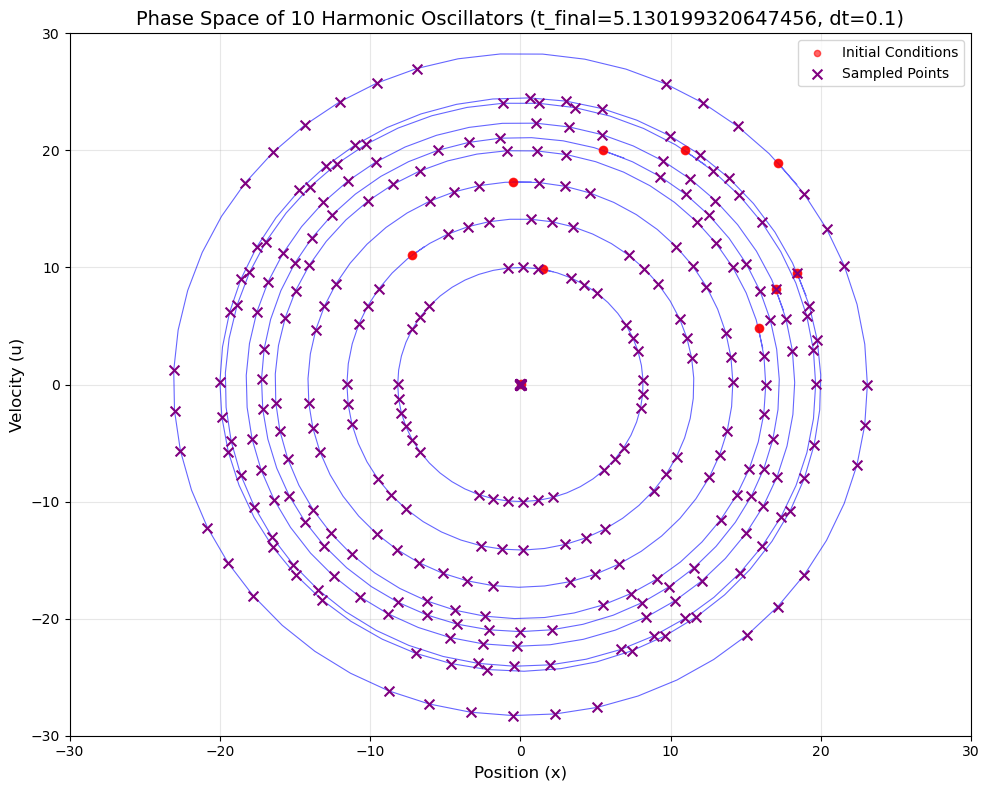

In [76]:
Phase.plot_phase_space(show_sampled=True, show_derivative=False, show_generated=True, plot_limits=None)

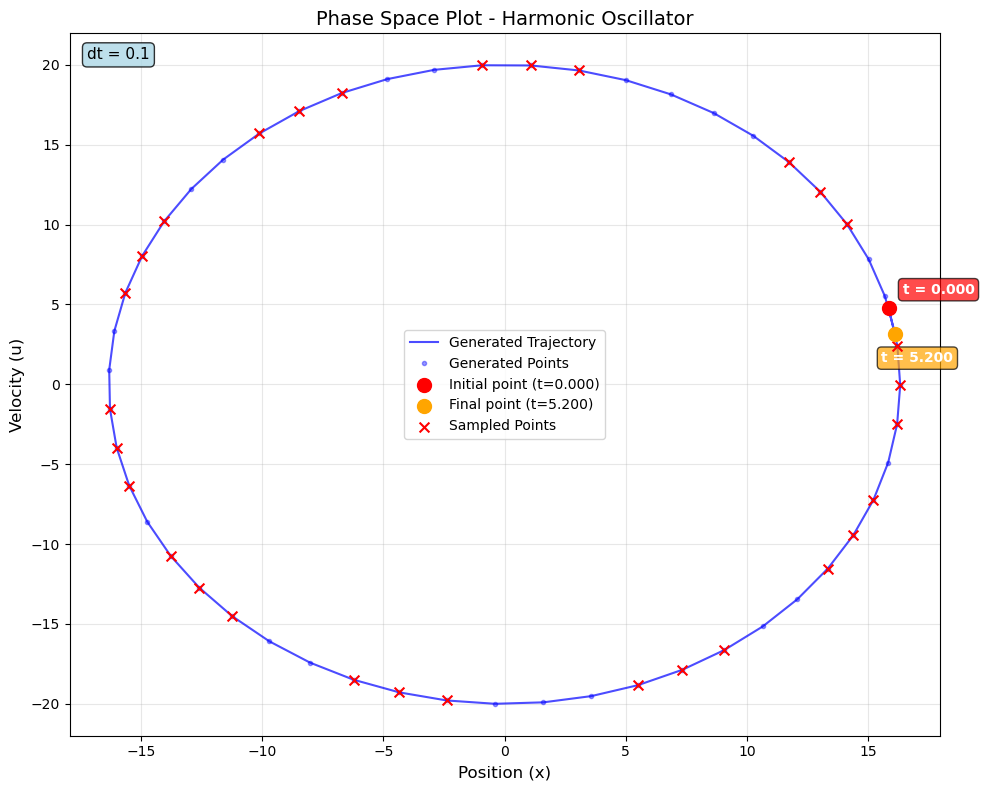

In [77]:
Phase.oscillators[4].plot_points(show_sampled=True, show_derivative=False, show_generated=True)